# Dominant Wavelength

- https://www.semrock.com/Data/Sites/1/semrockpdfs/whitepaper_howtocalculateluminositywavelengthandpurity.pdf
- http://www.madebydelta.com/imported/images/documents/ICAM/I103%20Dominant%20Wavelength.pdf

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot
import numpy as np
import pylab
from matplotlib.collections import LineCollection
from collections import namedtuple

from colour import (
    XYZ_to_xy,
    CMFS,
    DRAGON_COLOR_2_COLOURSPACE,
    ILLUMINANTS,
    tsplit,
    tstack,
    warning)
from colour.plotting import *

SegmentsIntersections_Specification = namedtuple(
    'SegmentsIntersections_Specification',
    ('intersect', 'xy', 'd1', 'd2', 'parallels', 'coincidents'))


def segments_intersections(xy1, xy2):
    # http://www.mathworks.com/matlabcentral/fileexchange/27205-fast-line-segment-intersection
    xy1 = np.reshape(xy1, (-1, 4))
    xy2 = np.reshape(xy2, (-1, 4))

    r1, c1 = xy1.shape[0], xy1.shape[1]
    r2, c2 = xy2.shape[0], xy2.shape[1]

    x1, y1, x2, y2 = [np.tile(xy1[:, i, np.newaxis], (1, r2)) for i in range(c1)]

    xy2 = np.transpose(xy2)

    x3, y3, x4, y4 = [np.tile(xy2[i, :], (r1, 1)) for i in range(c2)]

    x4_x3 = x4 - x3
    y1_y3 = y1 - y3
    y4_y3 = y4 - y3
    x1_x3 = x1 - x3
    x2_x1 = x2 - x1
    y2_y1 = y2 - y1

    numerator_a = x4_x3 * y1_y3 - y4_y3 * x1_x3
    numerator_b = x2_x1 * y1_y3 - y2_y1 * x1_x3
    denominator = y4_y3 * x2_x1 - x4_x3 * y2_y1

    u_a = numerator_a / denominator
    u_b = numerator_b / denominator

    intersect = np.logical_and.reduce(
        (u_a >= 0, u_a <= 1, u_b >= 0, u_b <= 1))
    xy = tstack((x1 + x2_x1 * u_a, y1 + y2_y1 * u_a))
    xy[~intersect] = np.nan
    parallels = denominator == 0
    coincidents = np.logical_and.reduce(
        (numerator_a == 0, numerator_b == 0, parallels))
    
    return SegmentsIntersections_Specification(
        intersect, xy, u_a, u_b, parallels, coincidents)

//anaconda/envs/colour-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


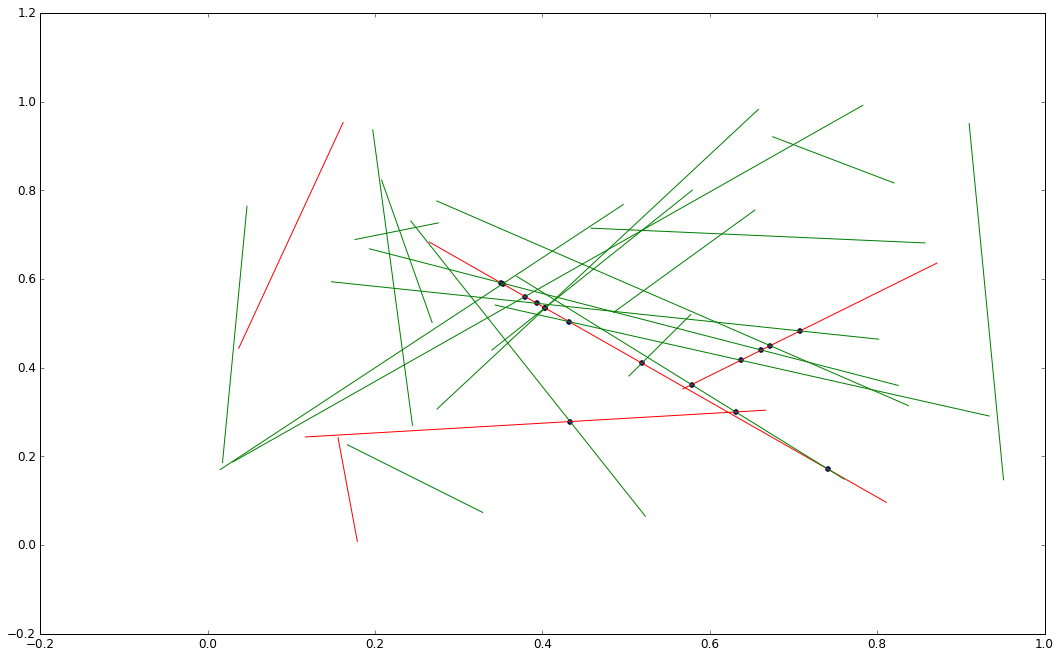

In [3]:
xy1 = np.random.rand(5, 2, 2)
xy2 = np.random.rand(20, 2, 2)

p = segments_intersections(xy1, xy2)

xy1_l = LineCollection(xy1, colors='red')
xy2_l = LineCollection(xy2, colors='green')

figure, axes = matplotlib.pyplot.subplots()

axes.add_collection(xy1_l)
axes.add_collection(xy2_l)
for i in range(xy1.shape[0]):
    matplotlib.pyplot.scatter(p.xy[i, :, 0], p.xy[i, :, 1])

In [4]:
def euclidean_distance(a, b):
    return np.linalg.norm(np.asarray(a) - np.asarray(b), axis=-1)


def extend_segment(a, b, length=1):
    # http://stackoverflow.com/questions/7740507/extend-a-line-segment-a-specific-distance
    ax, ay = tsplit(a)
    bx, by = tsplit(b)

    d = euclidean_distance(a, b)

    cx = bx + (bx - ax) / d * length
    cy = by + (by - ay) / d * length

    c = tstack((cx, cy))

    return c


def closest_spectral_locus_wavelength(xy1, xy2, xy_c, reverse=False):
    xy1 = np.asarray(xy1)
    xy2 = np.asarray(xy2)
    xy_c = np.asarray(xy_c)

    xy3 = (extend_segment(xy1, xy2)
           if reverse else
           extend_segment(xy2, xy1))

    # Closing horse-shoe shape.
    xy_c = np.vstack((xy_c, xy_c[0, :]))

    xy_w = segments_intersections(
        np.hstack((xy2, xy3)),
        np.hstack((xy_c, np.roll(xy_c, 1, axis=0)))).xy
    xy_w = xy_w[~np.isnan(xy_w).any(axis=-1)]

    i_w = np.argmin(euclidean_distance(xy_w, xy_c))

    return i_w, xy_w


def dominant_wavelength(xy,
                        xy_n,
                        cmfs=CMFS['CIE 1931 2 Degree Standard Observer'],
                        reverse=False):
    xy_c = XYZ_to_xy(cmfs.values)

    i_w, xy_w = closest_spectral_locus_wavelength(xy, xy_n, xy_c, reverse)
    xy_cw = xy_w
    w = cmfs.wavelengths[i_w]

    xy3 = extend_segment(xy, xy_n) if reverse else extend_segment(xy_n, xy)
    intersect = segments_intersections(
        np.hstack((xy_n, xy3)),
        np.hstack((xy_c[0], xy_c[-1]))).intersect
    if np.all(intersect):
        t1 = ('complementary wavelength'
              if reverse else
              'dominant wavelength')
        t2 = ('dominant complementary wavelength'
              if reverse else
              'complementary dominant wavelength')
        warning('"{0}" chromaticity coordinates have no "{1}", '
                'computing "{2}" in lieu!'.format(xy, t1, t2))
        i_w, xy_cw = closest_spectral_locus_wavelength(xy, xy_n, xy_c, True)
        w = -cmfs.wavelengths[i_w]

    return w, np.squeeze(xy_w), np.squeeze(xy_cw)


def complementary_wavelength(xy,
                             xy_n,
                             cmfs=CMFS['CIE 1931 2 Degree Standard Observer']):
    return (dominant_wavelength(xy, xy_n, cmfs, True))


def excitation_purity(xy,
                      xy_n,
                      cmfs=CMFS['CIE 1931 2 Degree Standard Observer']):
    w, xy_w, xy_cw = dominant_wavelength(xy, xy_n, cmfs)

    P_e = euclidean_distance(xy_n, xy) / euclidean_distance(xy_n, xy_w)

    return P_e


def colorimetric_purity(xy,
                        xy_n,
                        cmfs=CMFS['CIE 1931 2 Degree Standard Observer']):
    xy = np.asarray(xy)
    w, xy_w, xy_cw = dominant_wavelength(xy, xy_n, cmfs)
    P_e = excitation_purity(xy, xy_n, cmfs)

    P_c = P_e * xy_w[1] / xy[1]

    return P_c

(-533.0, array([ 0.39594147,  0.10777934]), array([ 0.17428921,  0.79394651]))


/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in divide
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in greater_equal
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in less_equal
/Users/kelsolaar/Documents/Development/colour-science/colour/colour/utilities/verbose.py:125: UserWarning: "(0.35, 0.25)" chromaticity coordinates have no "dominant wavelength", computing "complementary dominant wavelength" in lieu!
  warn(*args, **kwargs)


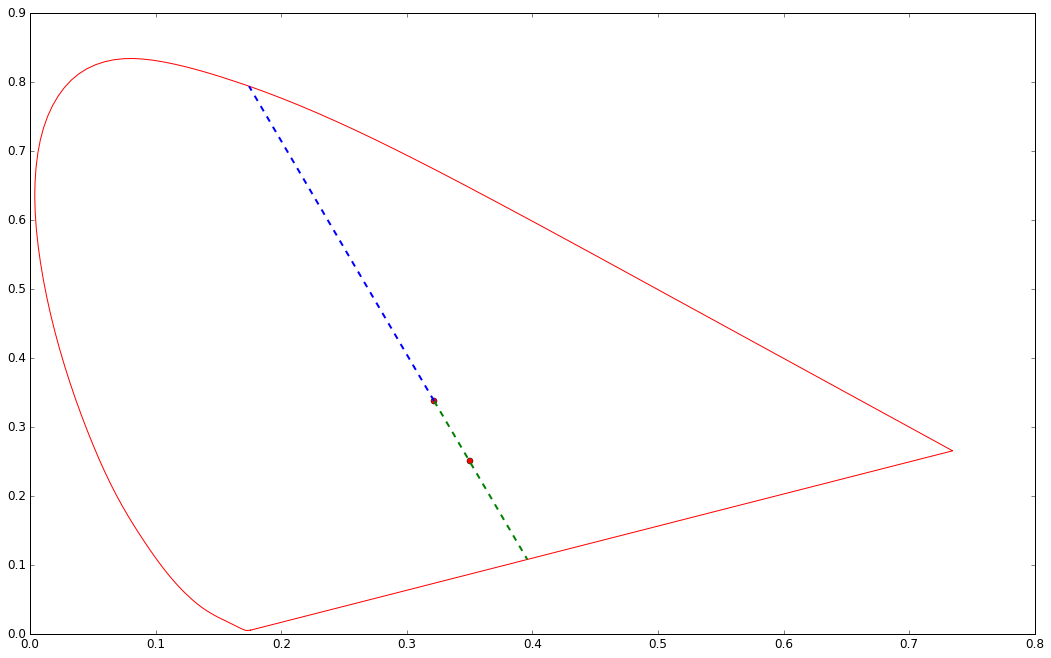

In [5]:
D60 = ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D60']
cmfs = CMFS['CIE 1931 2 Degree Standard Observer']

xy_c = XYZ_to_xy(cmfs.values)
xy_c = np.vstack((xy_c, xy_c[0, :]))
x_c, y_c = tsplit(xy_c)
pylab.plot(x_c, y_c)

xy = (0.35, 0.25)
w, xy_w, xy_cw = dominant_wavelength(xy, D60)
print(w, xy_w, xy_cw)
pylab.plot((D60[0], xy[0]), (D60[1], xy[1]), 'o', color='red')
pylab.plot((D60[0], xy_w[0]), (D60[1], xy_w[1]), '--', color='green', linewidth=2)
pylab.plot((D60[0], xy_cw[0]), (D60[1], xy_cw[1]), '--', color='blue', linewidth=2)

/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in divide
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in greater_equal
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in less_equal


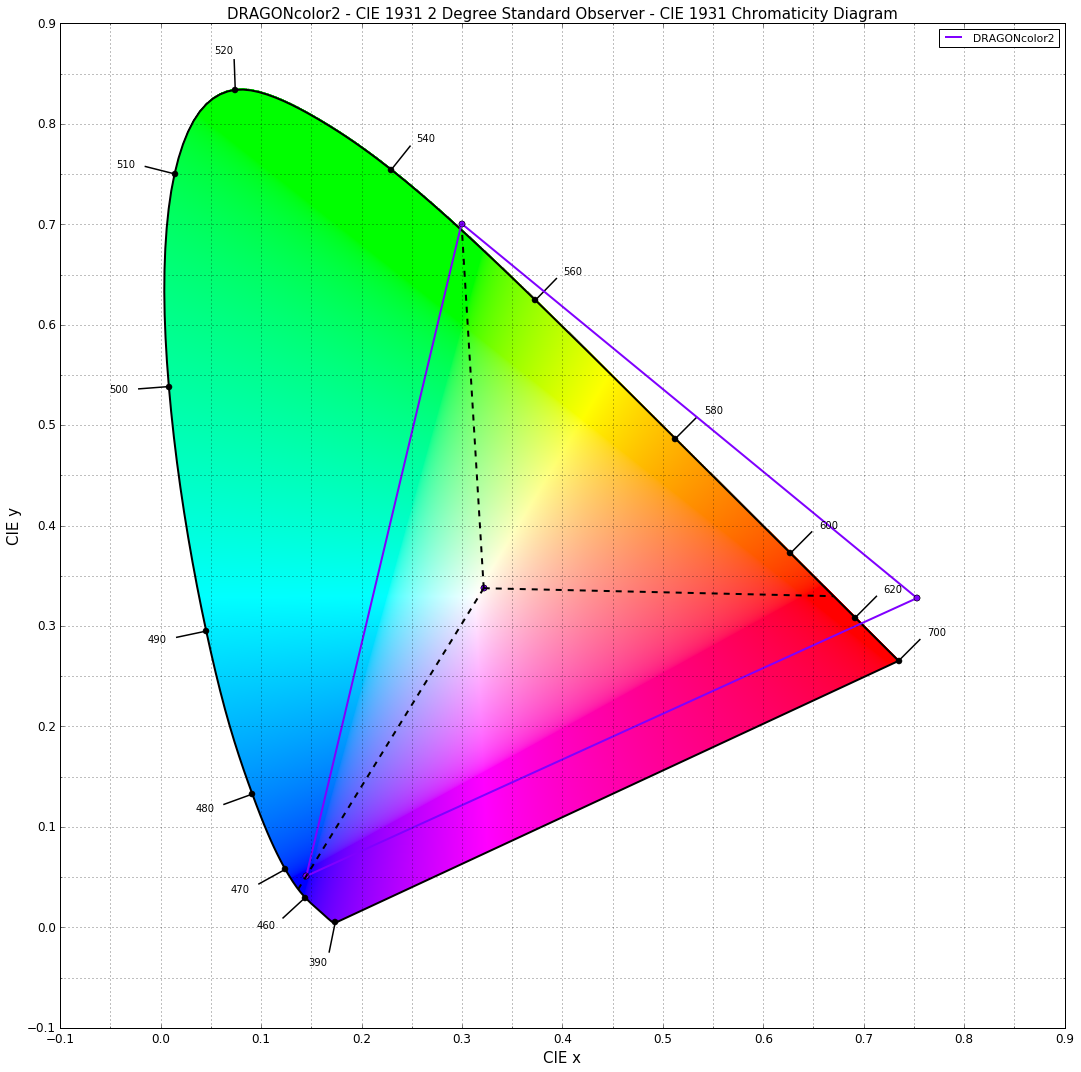

In [6]:
RGB_colourspaces_CIE_1931_chromaticity_diagram_plot(['DRAGONcolor2'], standalone=False)

for p in DRAGON_COLOR_2_COLOURSPACE.primaries:
    w, xy_w, xy_cw = dominant_wavelength(p, D60)
    pylab.plot((D60[0], xy_w[0]), (D60[1], xy_w[1]), '--', color='black', linewidth=2)

/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in divide
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in greater_equal
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in less_equal
/Users/kelsolaar/Documents/Development/colour-science/colour/colour/utilities/verbose.py:125: UserWarning: "[ 0.29957049  0.70069942]" chromaticity coordinates have no "complementary wavelength", computing "dominant complementary wavelength" in lieu!
  warn(*args, **kwargs)


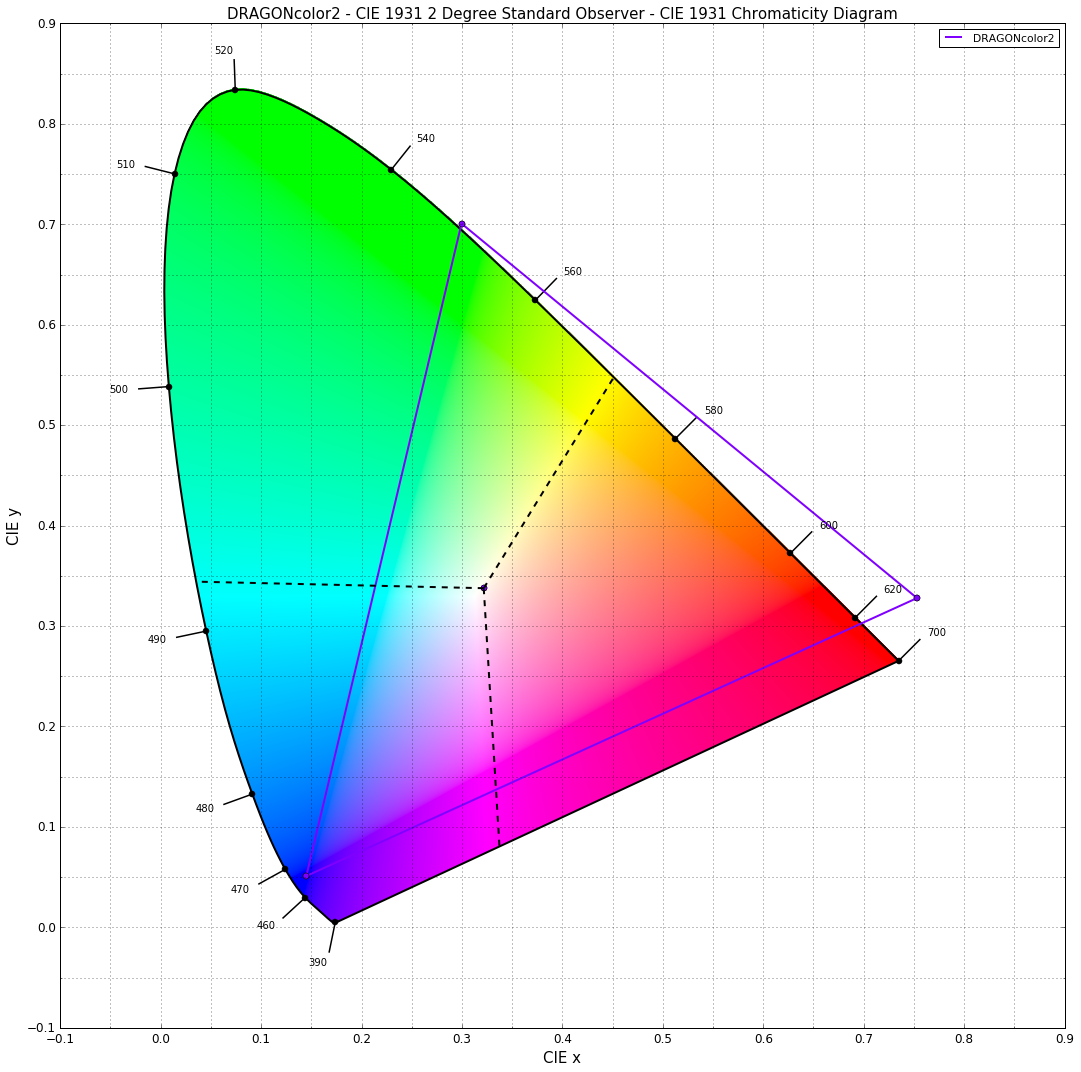

In [7]:
RGB_colourspaces_CIE_1931_chromaticity_diagram_plot(['DRAGONcolor2'], standalone=False)

for p in DRAGON_COLOR_2_COLOURSPACE.primaries:
    try:
        w, xy_w, xy_cw = complementary_wavelength(p, D60)
        pylab.plot((D60[0], xy_w[0]), (D60[1], xy_w[1]), '--', color='black', linewidth=2)
    except RuntimeError as e:
        print(e)
        

In [8]:
xy = (0.2835, 0.6870)
E = ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['E']
print('Dominant Wavelength: {0}'.format(dominant_wavelength(xy, E)))
print('Excitation Purity: {0}'.format(excitation_purity(xy, E)))
print('Colorimetric Purity: {0}'.format(colorimetric_purity(xy, E)))


Dominant Wavelength: (547.0, array([ 0.28000013,  0.71183857]), array([ 0.28000013,  0.71183857]))
Excitation Purity: 0.934377203126
Colorimetric Purity: 0.968159729804


/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in divide
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in greater_equal
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in less_equal
